In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
from collections import defaultdict
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import csv 
from collections import namedtuple
import os
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt



In [61]:
# Loading the CSV files as dictionaries to respective variables 

with open('lecturers.csv', newline='', encoding='utf-8') as lecturers: 
    reader = csv.DictReader(lecturers)
    lecturers = list(reader)

with open('courses.csv', newline='', encoding='utf-8') as courses: 
    reader = csv.DictReader(courses)
    courses = list(reader)

with open('timeslots.csv', newline='', encoding='utf-8') as timeslots: 
    reader = csv.DictReader(timeslots)
    timeslots = list(reader)

with open('rooms.csv', newline='', encoding='utf-8') as rooms: 
    reader = csv.DictReader(rooms)
    rooms = list(reader)

with open('students.csv', newline='', encoding='utf-8') as students: 
    reader = csv.DictReader(students)
    students = list(reader)

In [62]:
def fitness_function(timetable, courses, rooms, students):
    # Constants (tune these as needed)
    ROOM_OVERLOAD_PENALTY = 3
    CONFLICT_PENALTY = 5
    STUDENT_OVERLOAD_PENALTY = 5
    STUDENT_BURNOUT_PENALTY = 8
    VALID_SESSION_REWARD = 10
    IDEAL_STUDENT_DAY_REWARD = 2
    NO_CONFLICT_REWARD = 3

    score, penalty = 0, 0
    room_time_slots = set()
    lecturer_time_slots = set()
    student_exam_days = {}
    course_schedule = {}

    if timetable is None or any(s is None for s in timetable):
        return -10000  # Hard failure

    # Validate and reward individual sessions
    for session in timetable:
        course_id, lecturer_id, day, timeslot, room_id = session
        course_schedule[course_id] = (day, timeslot)

        course = courses.get(str(course_id))  # course keys may be strings
        room = rooms.get(str(room_id))

        if not course or not room:
            penalty += CONFLICT_PENALTY
            continue

        session_penalty = 0
        session_reward = 0

        # Room capacity constraint
        if int(course["students_enrolled"]) > int(room["room_capacity"]):
            session_penalty += ROOM_OVERLOAD_PENALTY
        else:
            session_reward += 2  # Slight bonus for fitting perfectly

        # Room/time conflict
        if (room_id, day, timeslot) in room_time_slots:
            session_penalty += CONFLICT_PENALTY
        else:
            room_time_slots.add((room_id, day, timeslot))
            session_reward += NO_CONFLICT_REWARD

        # Lecturer/time conflict
        if (lecturer_id, day, timeslot) in lecturer_time_slots:
            session_penalty += CONFLICT_PENALTY
        else:
            lecturer_time_slots.add((lecturer_id, day, timeslot))

        if session_penalty == 0:
            session_reward += VALID_SESSION_REWARD

        score += session_reward
        penalty += session_penalty

    # Student daily exam load
    for student in students:
        student_id = student['student_id']
        student_exam_days[student_id] = {}
        course_ids = [student[f'course{i}'] for i in range(1, 6)]
        course_ids = [str(cid) for cid in course_ids if cid]

        for cid in course_ids:
            if cid not in course_schedule:
                continue
            day, _ = course_schedule[cid]
            student_exam_days[student_id][day] = student_exam_days[student_id].get(day, 0) + 1

        for day, count in student_exam_days[student_id].items():
            if count == 1:
                score += IDEAL_STUDENT_DAY_REWARD
            elif count > 2:
                penalty += STUDENT_BURNOUT_PENALTY
            elif count > 1:
                penalty += STUDENT_OVERLOAD_PENALTY

    # Final fitness
    final_fitness = score - penalty
    return max(final_fitness, -1000)  # Normalise: avoid runaway negatives



def get_fitness_scores(population, fitness_func):
    def safe_fitness(individual):
        try:
            return fitness_func(individual, courses, rooms, students)
        except:
            return -float("inf")  # Penalise bad or broken individuals

    return [safe_fitness(ind) for ind in population if ind is not None]



In [63]:
courses = {c["course_id"]: c for c in courses}
course_ids = list(courses.keys())
rooms = {r["room_id"]: r for r in rooms}
room_ids = list(rooms.keys())
lecturer_ids = [l["lecturer_id"] for l in lecturers]
time_slots = [(t["day"], t["timeslot"]) for t in timeslots]


# Generates a random timetable with one session for each course 
def generate_timetable(): 
    timetable = []
    for course_id in course_ids: 
        lecturer_id = random.choice(lecturer_ids)
        room_id = random.choice(room_ids)
        day, timeslot = random.choice(time_slots)
        session = (course_id, lecturer_id, day, timeslot, room_id)
        timetable.append(session)
    return timetable 

In [64]:
# Uses the previous function to generate a list (size 'size') of timetables 
def initialise_population_rand(size): 
    return [generate_timetable() for _ in range(size)]

# Exponential rank based parent selection
def select_parents_rank_based(population, num_parents=None):
    n = len(population)
    if n < 2:
        raise ValueError("Population size too small for rank-based selection.")

    sorted_population = sorted(population, key=lambda ind: fitness_function(ind, courses, rooms, students), reverse=True)

    # Generate probabilities
    ranks = list(range(1, n + 1))
    c = sum(ranks)
    probabilities = np.array(ranks[::-1]) / c  # higher rank, higher probability

    # Determine how many parents to select
    if num_parents is None:
        num_parents = n  # default to selecting as many as the current population

    selected_indices = np.random.choice(n, size=num_parents, replace=True, p=probabilities)
    parents = [sorted_population[i] for i in selected_indices]

    return parents



def cycle_crossover(parent1, parent2):
    """Cycle crossover that swaps scheduling fields (day/time/room)"""
    size = len(parent1)
    child1 = parent1.copy()
    child2 = parent2.copy()
    visited = [False] * size

    while not all(visited):
        start = next(i for i, v in enumerate(visited) if not v)
        idx = start
        cycle = []

        while True:
            cycle.append(idx)
            visited[idx] = True
            target_cid = parent2[idx][0]
            idx = next(i for i, p in enumerate(parent1) if p[0] == target_cid)
            if idx == start:
                break

        for i in cycle:
            # Swap day/time/room (course and lecturer remain fixed)
            cid1, lid1, d1, t1, r1 = child1[i]
            cid2, lid2, d2, t2, r2 = child2[i]
            child1[i] = (cid1, lid1, d2, t2, r2)
            child2[i] = (cid2, lid2, d1, t1, r1)

    return child1, child2




    
def insert_mutate(individual):
    """Insert mutation with reassignment of session times/rooms"""
    mutated = individual.copy()
    size = len(mutated)

    if size < 2:
        return mutated

    # Choose two positions to swap with insert logic
    i, j = random.sample(range(size), 2)
    gene = mutated.pop(i)
    mutated.insert(j, gene)

    # Also randomly mutate one of the fields (day/timeslot/room)
    k = random.randint(0, size - 1)
    course_id, lecturer_id, day, timeslot, room_id = mutated[k]
    new_day, new_timeslot = random.choice(time_slots)
    new_room = random.choice(room_ids)
    mutated[k] = (course_id, lecturer_id, new_day, new_timeslot, new_room)

    return mutated


def survivor_selection_mu_lambda(offspring, mu):
    # Filter out broken individuals
    valid_offspring = [ind for ind in offspring if ind is not None and all(s is not None for s in ind)]
    
    if len(valid_offspring) < mu:
        print(f"⚠️ Not enough valid individuals for survivor selection (mu={mu}). Reinitialising some.")
        while len(valid_offspring) < mu:
            valid_offspring.append(generate_timetable())  # or random fallback

    fitness_scores = get_fitness_scores(valid_offspring, fitness_func=fitness_function)
    sorted_indices = sorted(range(len(valid_offspring)), key=lambda i: fitness_scores[i], reverse=True)
    
    next_generation = [valid_offspring[i] for i in sorted_indices[:mu]]
    return next_generation


# Diversity through shared fitness function
def course_order_distance(ind1, ind2):
    return sum(1 for a, b in zip(ind1, ind2) if a[0] != b[0])

def shared_fitness(population, distance_func, sigma=1.0, alpha=1.0):
    """
    Parameters:
    - population: list of individuals (solutions)
    - distance_func: function taking (ind1, ind2) and returning float distance
    - sigma: niche radius (σ)
    - alpha: sharing shape factor
    """
    raw_fitnesses = get_fitness_scores(population, fitness_func=fitness_function)
    mu = len(population)
    shared_fitnesses = []

    for i in range(mu): 
        sharing_sum = 0.0
        for j in range(mu): 
            if i == j: 
                d = 0
            else: 
                d = distance_func(population[i], population[j])
            
            # Sharing function sh(d) 
            if d <= sigma: 
                sh = 1 - (d / sigma) ** alpha
            else: 
                sh = 0

            sharing_sum += sh

            # avoid div by 0 
            if sharing_sum == 0:
                sharing_sum = 1e-8 
            
            f_shared = raw_fitnesses[i] / sharing_sum
            shared_fitnesses.append(f_shared)

    return shared_fitnesses

In [65]:
# "Greedy" population initialisation functions. Operates within constraints. (constraint-aware generation)
# More likely to generate valid, or near-valid timetables that have higher fitness to begin with.
from collections import defaultdict
import random

# Build course-to-student map from students.csv (to respect that students shouldn't have more than 2 exams per day)
course_students = defaultdict(set)
for student in students:
    student_id = student["student_id"]
    for i in range(1, 6):
        course_id = int(student[f"course{i}"])
        course_students[course_id].add(student_id)

def initialise_population_greedy(size):
    population = []

    for _ in range(size):
        timetable = []
        used_room_slots = set()
        used_lecturer_slots = set()
        student_exam_days = defaultdict(lambda: defaultdict(int))  # student_id -> day -> exam count

        for course_id in course_ids:
            assigned = False
            course = courses.get(str(course_id))


            for day, timeslot in time_slots:
                overload_found = False

                # Check if any student in the course already has 2 exams that day
                for student_id in course_students[course_id]:
                    if student_exam_days[student_id][day] >= 2:
                        overload_found = True
                        break
                if overload_found:
                    continue

                for room_id in room_ids:
                    room = rooms.get(str(room_id))
                    if not room or int(course["students_enrolled"]) > int(room["room_capacity"]):
                        continue

                    for lecturer_id in lecturer_ids:
                        room_slot = (room_id, day, timeslot)
                        lecturer_slot = (lecturer_id, day, timeslot)

                        if room_slot in used_room_slots or lecturer_slot in used_lecturer_slots:
                            continue

                        # Assign session
                        session = (course_id, lecturer_id, day, timeslot, room_id)
                        timetable.append(session)
                        used_room_slots.add(room_slot)
                        used_lecturer_slots.add(lecturer_slot)

                        # Record student exam assignment
                        for student_id in course_students[course_id]:
                            student_exam_days[student_id][day] += 1

                        assigned = True
                        break
                    if assigned:
                        break
                if assigned:
                    break

            # Fallback to random session if nothing valid found
            if not assigned:
                lecturer_id = random.choice(lecturer_ids)
                room_id = random.choice(room_ids)
                day, timeslot = random.choice(time_slots)
                session = (course_id, lecturer_id, day, timeslot, room_id)
                timetable.append(session)

        population.append(timetable)

    return population


# Fitness proportionate parent selection (FPS)
def parent_select_fitness_proportionate(population, num_parents=None):
    """
    Selects parents proportionally to their (possibly negative) fitness scores.
    Uses linear scaling to ensure all fitness values are positive.

    Parameters:
    - population: list of individuals
    - num_parents: number of parents to return (defaults to population size)

    Returns:
    - List of selected parents
    """
    if num_parents is None:
        num_parents = len(population)

    fitness_scores = [fitness_function(ind, courses, rooms, students) for ind in population]

    min_fitness = min(fitness_scores)
    shift = -min_fitness + 1e-6 if min_fitness < 0 else 0.0  # Ensure strictly positive

    scaled_fitness = [f + shift for f in fitness_scores]
    total_fitness = sum(scaled_fitness)

    if total_fitness == 0:
        probabilities = [1 / len(population)] * len(population)
    else:
        probabilities = [f / total_fitness for f in scaled_fitness]

    selected_indices = np.random.choice(len(population), size=num_parents, replace=True, p=probabilities)
    return [population[i] for i in selected_indices]



# Order crossover (returns two children)
def order_crossover(parent1, parent2):
    """Modified order crossover that swaps scheduling fields"""
    size = len(parent1)
    p1, p2 = sorted(random.sample(range(size), 2))

    child1 = parent1.copy()
    child2 = parent2.copy()

    for i in range(p1, p2):
        # swap time-related fields while keeping course/lecturer the same
        cid1, lid1, d1, t1, r1 = child1[i]
        cid2, lid2, d2, t2, r2 = child2[i]

        # swap schedule-related parts
        child1[i] = (cid1, lid1, d2, t2, r2)
        child2[i] = (cid2, lid2, d1, t1, r1)

    return child1, child2


def scramble_mutate(individual):
    """Scramble-mutate with updated session assignments"""
    mutated = individual.copy()
    size = len(mutated)

    if size < 2:
        return mutated

    # Select a subsegment
    i, j = sorted(random.sample(range(size), 2))

    for idx in range(i, j):
        course_id, lecturer_id, _, _, _ = mutated[idx]
        new_day, new_timeslot = random.choice(time_slots)
        new_room = random.choice(room_ids)
        mutated[idx] = (course_id, lecturer_id, new_day, new_timeslot, new_room)

    return mutated


def survivor_selection_round_robin(parents, offspring, mu, q=10):
    combined = [ind for ind in (parents + offspring) if ind is not None and all(s is not None for s in ind)]
    
    if len(combined) < mu:
        print(f"⚠️ Not enough valid individuals for round robin (mu={mu}). Reinitialising some.")
        while len(combined) < mu:
            combined.append(generate_timetable())

    fitness_scores = get_fitness_scores(combined, fitness_func=fitness_function)
    num_individuals = len(combined)
    win_counts = [0] * num_individuals

    for i in range(num_individuals):
        opponents = random.sample([j for j in range(num_individuals) if j != i], k=min(q, num_individuals - 1))
        for j in opponents:
            if fitness_scores[i] > fitness_scores[j]:
                win_counts[i] += 1

    ranked_indices = sorted(range(num_individuals), key=lambda i: win_counts[i], reverse=True)
    selected_indices = ranked_indices[:mu]
    next_generation = [combined[i] for i in selected_indices]

    return next_generation



    

In [66]:
def is_valid_individual(ind):
    return (
        ind is not None and
        isinstance(ind, list) and
        all(
            isinstance(s, tuple) and len(s) == 5 and all(e is not None for e in s)
            for s in ind
        )
    )


def run_ga(config, courses, rooms, students, course_ids, lecturer_ids, room_ids, time_slots, generations=50, mu=100):
    """
    Runs one full GA loop using a specific GAConfig.
    Returns:
    - best_individual: the highest-fitness timetable from the final generation
    - fitness_trend: list of best fitness values per generation
    """
    mutation_rate = 0.3
    population = config.init_func(mu)
    population = [ind for ind in population if is_valid_individual(ind)]
    print("✅ Initial population:", len(population))

    fitness_trend = []

    for gen in range(generations):
        print(f"\n📘 Generation {gen + 1}")

        raw_scores = get_fitness_scores(population, fitness_function)
        print("   📊 Population size before parent selection:", len(population))

        parents = config.parent_select_func(population, mu)
        print("   👪 Selected parents:", len(parents))

        # Track how many offspring we try to create
        offspring = []
        for i in range(0, len(parents), 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % len(parents)]
            result = config.crossover_func(p1, p2)
            # Ensure we're always working with a list of individuals

            # Ensure we always get a list of full individuals (each a list of sessions)
            if isinstance(result, list) and isinstance(result[0], tuple):
                # result is a single child (list of sessions)
                children = [result]
            else:
                # result is likely a list of individuals (from order_crossover)
                children = result


            for child in children:
                if not is_valid_individual(child):
                    print("   ⚠️ Invalid child from crossover:", child)
                    continue

                # Apply mutation
                if random.random() < mutation_rate:
                    mutated = config.mutation_func(child)
                else:
                    mutated = child

                if not is_valid_individual(mutated):
                    print("   ⚠️ Invalid mutated child:", mutated)
                else:
                    offspring.append(mutated)

        print("   🧬 Total offspring generated:", len(offspring))

        if len(offspring) < mu:
            print(f"   ⚠️ Not enough valid offspring (have {len(offspring)}, need {mu}). Reinitialising...")
            while len(offspring) < mu:
                new_ind = generate_timetable()
                if is_valid_individual(new_ind):
                    offspring.append(new_ind)

        # Survivor selection
        if config.survivor_select_func.__name__ == "survivor_selection_round_robin":
            population = config.survivor_select_func(parents, offspring, mu)
        elif config.survivor_select_func.__name__ == "survivor_selection_mu_lambda":
            population = config.survivor_select_func(offspring, mu)
        else:
            raise ValueError(f"Unsupported survivor selection function: {config.survivor_select_func.__name__}")

        population = [ind for ind in population if is_valid_individual(ind)]
        print("   ✅ Population after survivor selection:", len(population))

        # Track fitness
        best_in_gen = max(population, key=lambda ind: fitness_function(ind, courses, rooms, students))
        fitness_trend.append(fitness_function(best_in_gen, courses, rooms, students))
    # Final best individual from last population
    best_individual = max(population, key=lambda ind: fitness_function(ind, courses, rooms, students))
    return best_individual, fitness_trend


In [67]:
GAConfig = namedtuple("GAConfig", [
    "label", "init_func", "parent_select_func", "crossover_func",
    "mutation_func", "survivor_select_func", "use_shared_fitness"
])

experiments = [

    GAConfig(
        label="Mutation: Insert",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Mutation: Scramble",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=scramble_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Crossover: Order",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Crossover: Cycle",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=cycle_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Parent Select: Rank",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Parent Select: Fitness Prop.",
        init_func=initialise_population_greedy,
        parent_select_func=parent_select_fitness_proportionate,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Survivor: μ,λ",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Survivor: Round Robin",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_round_robin,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Init: Random",
        init_func=initialise_population_rand,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Init: Greedy",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=order_crossover,
        mutation_func=insert_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=False
    ),

    GAConfig(
        label="Diversity: Shared Fitness + μ,λ",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=cycle_crossover,
        mutation_func=scramble_mutate,
        survivor_select_func=survivor_selection_mu_lambda,
        use_shared_fitness=True
    ),

    GAConfig(
        label="Diversity: Shared Fitness + Round Robin",
        init_func=initialise_population_greedy,
        parent_select_func=select_parents_rank_based,
        crossover_func=cycle_crossover,
        mutation_func=scramble_mutate,
        survivor_select_func=survivor_selection_round_robin,
        use_shared_fitness=True
    ),
]

def evaluate_setting(config, courses, rooms, students, course_ids, lecturer_ids, room_ids, time_slots, runs=30, generations=100, mu=100):
    """
    Repeatedly evaluates one GA configuration and returns summary statistics.
    """
    final_fitnesses = []
    best_individual_overall = None
    best_fitness_overall = float("-inf")

    for run_index in range(runs):
        print(f"\n▶️ Run {run_index + 1} / {runs} — {config.label}")

        best_individual, fitness_trend = run_ga(
            config=config,
            courses=courses,
            rooms=rooms,
            students=students,
            course_ids=course_ids,
            lecturer_ids=lecturer_ids,
            room_ids=room_ids,
            time_slots=time_slots,
            generations=generations,
            mu=mu
        )

        final_fitness = fitness_trend[-1]
        final_fitnesses.append(final_fitness)

        if final_fitness > best_fitness_overall:
            best_fitness_overall = final_fitness
            best_individual_overall = best_individual

    return {
        "label": config.label,
        "mean": np.mean(final_fitnesses),
        "std": np.std(final_fitnesses),
        "max": np.max(final_fitnesses),
        "min": np.min(final_fitnesses),
        "all": final_fitnesses,
        "best_solution": best_individual_overall
    }



# Ensure courses is a dict
if isinstance(courses, list):
    courses = {c["course_id"]: c for c in courses}

# Ensure rooms is a dict
if isinstance(rooms, list):
    rooms = {r["room_id"]: r for r in rooms}


results = []

for config in experiments:
    print(f"Running: {config.label}")
    result = evaluate_setting(
        config=config,
        courses=courses,
        rooms=rooms,
        students=students,
        course_ids=course_ids,
        lecturer_ids=lecturer_ids,
        room_ids=room_ids,
        time_slots=time_slots,
        runs=1
    )
    results.append(result)

# config = experiments[0]
# print(f"Running: {config.label}")
# result = evaluate_setting(
#     config=config,
#     courses=courses,
#     rooms=rooms,
#     students=students,
#     course_ids=course_ids,
#     lecturer_ids=lecturer_ids,
#     room_ids=room_ids,
#     time_slots=time_slots,
#     runs=1
# )



Running: Mutation: Insert

▶️ Run 1 / 1 — Mutation: Insert
✅ Initial population: 100

📘 Generation 1
   📊 Population size before parent selection: 100
   👪 Selected parents: 100
   🧬 Total offspring generated: 100
   ✅ Population after survivor selection: 100

📘 Generation 2
   📊 Population size before parent selection: 100
   👪 Selected parents: 100
   🧬 Total offspring generated: 100
   ✅ Population after survivor selection: 100

📘 Generation 3
   📊 Population size before parent selection: 100
   👪 Selected parents: 100
   🧬 Total offspring generated: 100
   ✅ Population after survivor selection: 100

📘 Generation 4
   📊 Population size before parent selection: 100
   👪 Selected parents: 100
   🧬 Total offspring generated: 100
   ✅ Population after survivor selection: 100

📘 Generation 5
   📊 Population size before parent selection: 100
   👪 Selected parents: 100
   🧬 Total offspring generated: 100
   ✅ Population after survivor selection: 100

📘 Generation 6
   📊 Population size bef

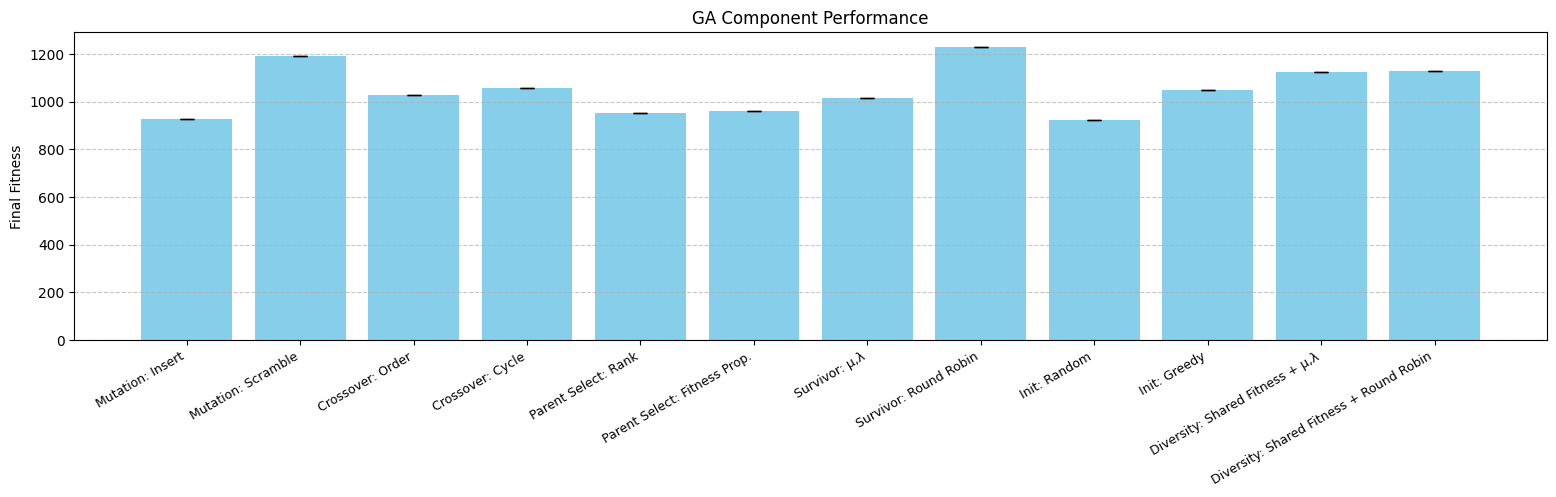

In [70]:
def launch_experiment_gui(results, courses, lecturers, time_slots):
    import tkinter as tk
    from tkinter import ttk
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
    import matplotlib.pyplot as plt

    # Build lookup maps
    course_names = {int(cid): c['course_name'] for cid, c in courses.items()}
    lecturer_names = {int(l['lecturer_id']): l['lecturer_name'] for l in lecturers}
    time_index = {t: i for i, t in enumerate(time_slots)}

    def update_timetable(selected_label):
        for row in timetable_tree.get_children():
            timetable_tree.delete(row)

        for res in results:
            if res["label"] == selected_label:
                timetable_sorted = sorted(
                    res["best_solution"],
                    key=lambda s: time_index.get((s[2], s[3]), 999)
                )
                for session in timetable_sorted:
                    course_id, lecturer_id, day, timeslot, room_id = session
                    course_name = course_names.get(int(course_id), f"Course {course_id}")
                    lecturer_name = lecturer_names.get(int(lecturer_id), f"Lecturer {lecturer_id}")
                    timetable_tree.insert("", "end", values=(course_name, lecturer_name, day, timeslot, room_id))
                break

    # GUI
    root = tk.Tk()
    root.title("GA Experiment Results")
    root.geometry("1200x800")

    # Summary Table
    tree_frame = ttk.Frame(root)
    tree_frame.pack(fill=tk.X, padx=10, pady=10)

    tree = ttk.Treeview(tree_frame, columns=("Label", "Mean", "Std", "Max", "Min"), show="headings", height=8)
    for col in tree["columns"]:
        tree.heading(col, text=col)
        tree.column(col, width=180 if col == "Label" else 80, anchor='center')
    tree.pack(fill=tk.X)

    for res in results:
        tree.insert("", "end", values=(res["label"], f"{res['mean']:.2f}", f"{res['std']:.2f}", res["max"], res["min"]))

    # Bar chart of mean fitness
    fig, ax = plt.subplots(figsize=(10, 4))
    labels = [res["label"] for res in results]
    means = [res["mean"] for res in results]
    stds = [res["std"] for res in results]
    x = range(len(labels))

    ax.bar(x, means, yerr=stds, capsize=5, color='skyblue')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=9)
    ax.set_ylabel("Final Fitness")
    ax.set_title("GA Component Performance")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.X, expand=False, padx=10, pady=(0, 10))

    # Dropdown to select experiment
    dropdown_frame = ttk.Frame(root)
    dropdown_frame.pack(pady=(0, 10))

    ttk.Label(dropdown_frame, text="Select Experiment to View Timetable:", font=("Arial", 10)).pack(side=tk.LEFT)

    config_selector = ttk.Combobox(dropdown_frame, values=labels, state="readonly", width=60)
    config_selector.pack(side=tk.LEFT, padx=10)

    # Timetable Table
    timetable_frame = ttk.Frame(root)
    timetable_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=(0, 10))

    timetable_tree = ttk.Treeview(timetable_frame, columns=("Course", "Lecturer", "Day", "Timeslot", "Room"), show="headings", height=15)
    for col in timetable_tree["columns"]:
        timetable_tree.heading(col, text=col)
        timetable_tree.column(col, width=180 if col == "Course" else 100, anchor='center')
    timetable_tree.pack(fill=tk.BOTH, expand=True)

    config_selector.bind("<<ComboboxSelected>>", lambda e: update_timetable(config_selector.get()))

    if labels:
        config_selector.set(labels[0])
        update_timetable(labels[0])

    root.mainloop()



launch_experiment_gui(results, courses, lecturers, time_slots)


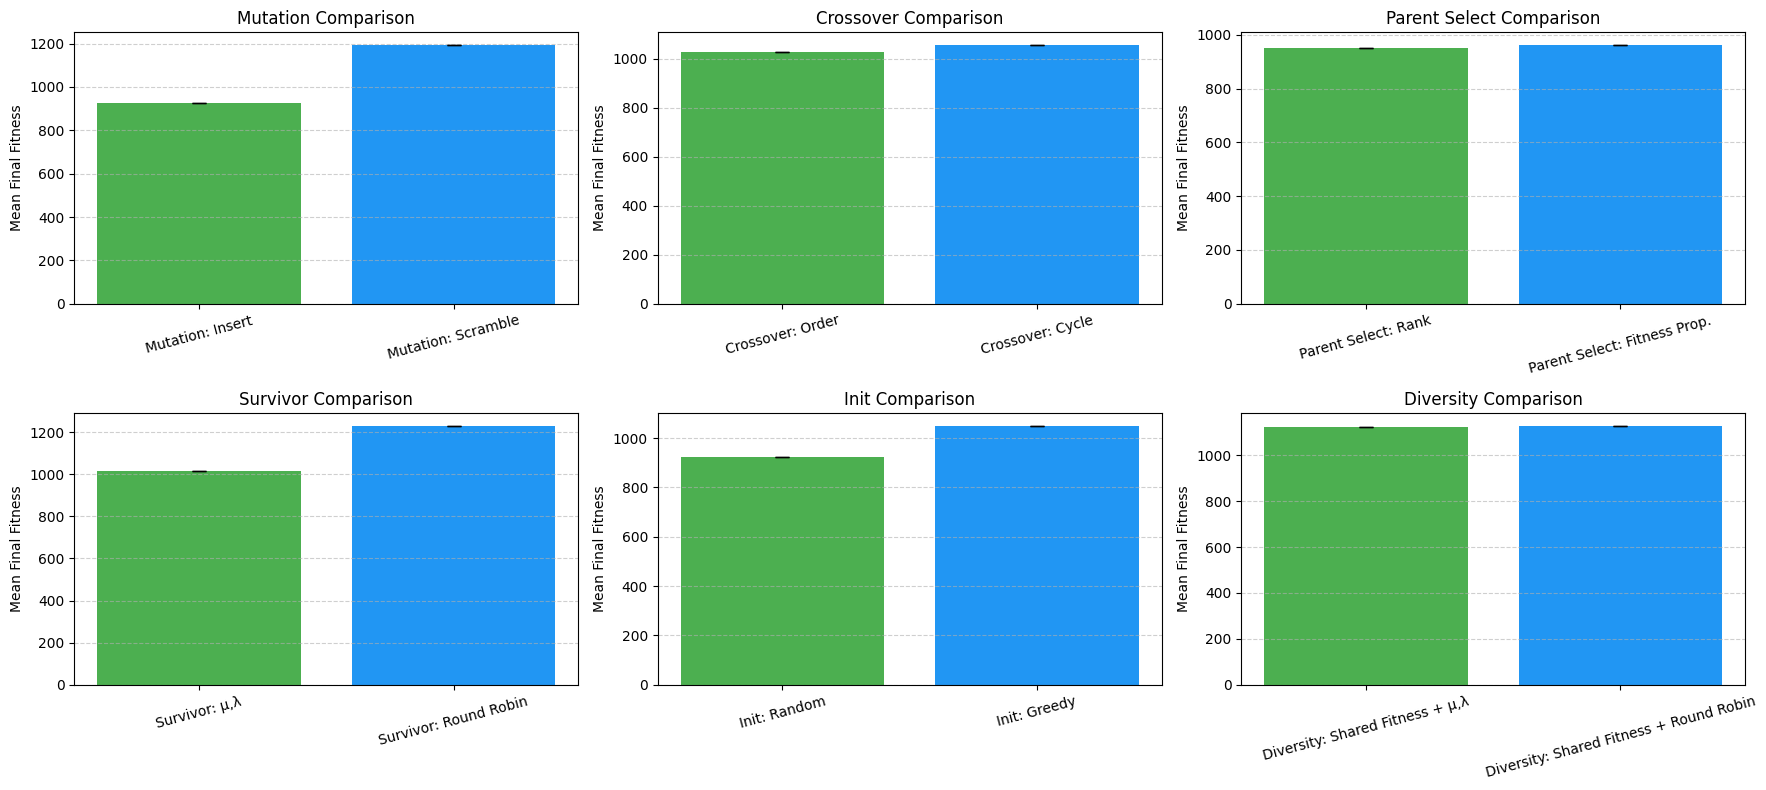

In [69]:
import matplotlib.pyplot as plt

# Helper to find result by label
def get_result(label):
    for r in results:
        if r['label'] == label:
            return r
    return None

# Pairs to compare
comparisons = [
    ("Mutation: Insert", "Mutation: Scramble"),
    ("Crossover: Order", "Crossover: Cycle"),
    ("Parent Select: Rank", "Parent Select: Fitness Prop."),
    ("Survivor: μ,λ", "Survivor: Round Robin"),
    ("Init: Random", "Init: Greedy"),
    ("Diversity: Shared Fitness + μ,λ", "Diversity: Shared Fitness + Round Robin")
]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for i, (label1, label2) in enumerate(comparisons):
    res1 = get_result(label1)
    res2 = get_result(label2)
    
    means = [res1['mean'], res2['mean']]
    stds = [res1['std'], res2['std']]
    labels = [label1, label2]
    
    axes[i].bar(labels, means, yerr=stds, capsize=5, color=['#4caf50', '#2196f3'])
    axes[i].set_title(f"{label1.split(':')[0]} Comparison")
    axes[i].set_ylabel("Mean Final Fitness")
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
